# Description

### TO-DO LIST:

### Build RIDGE, RF, ADA Model Capability (Find a Way To Brand These To Layman)
### Build TK Interface
### Add Logo Functionality
### Output Diagnostic Info For Model Eval (MSE, relevant dataViz)


List of Current Inputs:

Academic Pts
Athletic Pts
Social Pts
Exclusivity Pts
Affordability Pts

Location Mode Selection
- n-mile radius
- list of allowable states
- current location (city, state)

Model Mode Selection

In [7]:
import pandas as pd
import numpy as np
import os
import missingno as msno
import math

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import scipy.sparse as sp
    
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
import xgboost as xg
from sklearn.metrics import mean_squared_error as MSE

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import plot_confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import AdaBoostClassifier

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [8]:
# USER RANKING FUNCTION BELOW

def get_user_ranks():
    full_dataset = pd.read_csv('../data/Raw/Final_Dataset.csv')
           
    academics = pd.read_csv('../data/Raw/RK_Academics.csv')
    athletics = pd.read_csv('../data/Raw/RK_Athletics.csv')
    exclusive = pd.read_csv('../data/Raw/RK_Exclusivity.csv')
    social = pd.read_csv('../data/Raw/RK_Social.csv')
    affordability = pd.read_csv('../data/Raw/RK_Academics.csv')
    
    def get_importance_values():
        # This sub-fn will be replaced in final TK implementation
        print('Please Enter a Weight (0-100) For How Important\nYou Feel Each of the Following Factors Are In Your College Decision')
        print('\nAcademics:')
        academics=input()
        academics=int(academics)
        
        print('\nAthletics:')
        athletics=input()
        athletics=int(athletics)
        
        print('\nExclusivity / Presitge:')
        exclusive=input()
        exclusive=int(exclusive)
        
        print('\nSocial Life:')
        social=input()
        social=int(social)
        
        print('\nAffordability:')
        affordability=input()
        affordability=int(affordability)
        
        my_sum = academics + athletics + exclusive + social + affordability
        if my_sum == 0:
            raise Exception("AT LEAST ONE WEIGHTED VALUE MUST BE > 0")
        return academics, athletics, exclusive, social, affordability
    
    (w_aca, w_ath, w_exc, w_soc, w_aff) = get_importance_values()
    
    df = full_dataset.merge(academics,how='left',on='C_ID')
    df = df.drop('Rank',axis=1)
    df = df.rename(columns={'Points':'Academic_Pts'})
    df['Academic_Pts'] = df['Academic_Pts'].fillna(2)
    
    df = df.merge(athletics,how='left',on='C_ID')
    df = df.drop('Rank',axis=1)
    df = df.rename(columns={'Points':'Athletic_Pts'})
    df['Athletic_Pts'] = df['Athletic_Pts'].fillna(2)
    
    df = df.merge(exclusive,how='left',on='C_ID')
    df = df.drop('Rank',axis=1)
    df = df.rename(columns={'Points':'Exclusive_Pts'})
    df['Exclusive_Pts'] = df['Exclusive_Pts'].fillna(2)
    
    df = df.merge(social,how='left',on='C_ID')
    df = df.drop('Rank',axis=1)
    df = df.rename(columns={'Points':'Social_Pts'})
    df['Social_Pts'] = df['Social_Pts'].fillna(2)
    
    df = df.merge(affordability,how='left',on='C_ID')
    df = df.drop('Rank',axis=1)
    df = df.rename(columns={'Points':'Affordable_Pts'})
    df['Affordable_Pts'] = df['Affordable_Pts'].fillna(2)
    
    df['Academic_Pts'] = df['Academic_Pts'] * (w_aca/100)
    df['Athletic_Pts'] = df['Athletic_Pts'] * (w_ath/100)
    df['Exclusive_Pts'] = df['Exclusive_Pts'] * (w_exc/100)
    df['Social_Pts'] = df['Social_Pts'] * (w_soc/100)
    df['Affordable_Pts'] = df['Affordable_Pts'] * (w_aff/100)
    
    df['Dynamic_Pt_Total'] = df['Academic_Pts'] + df['Athletic_Pts'] + df['Exclusive_Pts'] + \
                             df['Social_Pts'] + df['Affordable_Pts']
    df.to_csv('../data/Interim/temp_df.csv')
    df = df.drop(['Social_Pts','Academic_Pts','Athletic_Pts','Exclusive_Pts','Affordable_Pts'],axis=1)
    
    df = df.sort_values(by='Dynamic_Pt_Total',ascending=False)
    i=1
    df['Rank'] = 0
    for idx,row in df.iterrows():
        df.at[idx,'Rank'] = i
        i=i+1
    
    #df = df.drop('Dynamic_Pt_Total',axis=1)
    df = df.reset_index()
    try:
        df = df.drop('index',axis=1)
    except:
        pass
    
    return df

In [9]:
# LOCATION DEVBOOK FUNCTION BELOW

def factor_location_data(df, location_mode):
    import geopy.distance
    from geopy.geocoders import Nominatim
    geolocator = Nominatim(user_agent='myapplication')
    
    def get_current_location():
        print('\nPlease Enter Your City And State Abbrev Separated By A Comma')
        my_loc = input()
        loc_list = my_loc.split(',')
        my_city = loc_list[0]
        my_state = loc_list[-1]
        my_state = my_state.strip()
        
        from geopy.geocoders import Nominatim
        
        location = geolocator.geocode(f"{my_city} {my_state}")
    
        my_lon = location.raw['lon']
        my_lat = location.raw['lat']
        
        return my_lon, my_lat
    
    def sigmoid(x):
        return 1 / (1 + math.exp(-x))

    if location_mode == 1:
        pass
    elif location_mode == 2:
        print('\nPlease Select Your n-Mile Radius')
        n = input()
        n = int(n)
        
        (current_lon, current_lat) = get_current_location()
        # Cutoff after n-miles
        geo_df = pd.read_csv('../data/Interim/College_GeoData.csv')
        try:
            geo_df = geo_df.drop('Unnamed: 0',axis=1)
        except:
            pass
        df = df.merge(geo_df,how='inner',on='C_ID')
        df['Current_Lon'] = current_lon
        df['Current_Lat'] = current_lat
        df['Distance_Miles'] = 0
        
        for idx,row in df.iterrows():
            coords_1 = (row['Current_Lat'],row['Current_Lon'])
            coords_2 = (row['Latitude'],row['Longitude'])

            my_dist = geopy.distance.geodesic(coords_1, coords_2).miles
            
            df.at[idx,'Distance_Miles'] = my_dist
        
        df = df[df['Distance_Miles']<=n]
        
        df = df.drop(['Distance_Miles','Current_Lon','Current_Lat','Longitude','Latitude'],axis=1)
        df = df.reset_index()
        try:
            df = df.drop('index',axis=1)
        except:
            pass
        
    elif location_mode == 3:
        (current_lon, current_lat) = get_current_location()
        
        # weight on logistic curve
        geo_df = pd.read_csv('../data/Interim/College_GeoData.csv')
        try:
            geo_df = geo_df.drop('Unnamed: 0',axis=1)
        except:
            pass
        df = df.merge(geo_df,how='inner',on='C_ID')
        df['Current_Lon'] = current_lon
        df['Current_Lat'] = current_lat
        df['Distance_Miles'] = 0
        
        for idx,row in df.iterrows():
            coords_1 = (row['Current_Lat'],row['Current_Lon'])
            coords_2 = (row['Latitude'],row['Longitude'])

            my_dist = geopy.distance.geodesic(coords_1, coords_2).miles
            
            df.at[idx,'Distance_Miles'] = my_dist
            
        target_col_name = 'Pred_Pts'
        # Min Max it, -0.5, multiply by 12 (-6,6) domain
        df['Distance_Miles_Scaled'] = (df['Distance_Miles'] / df['Distance_Miles'].abs().max()) #domain now 0,1
        df['Distance_Miles_Scaled'] = df['Distance_Miles_Scaled'] - 0.5 #domain now -0.5, 0.5
        df['Distance_Miles_Scaled'] = df['Distance_Miles_Scaled'] * 12 # domain now -6,6
        
        df['scaler'] = 0.0
        for idx,row in df.iterrows():
            my_sig = sigmoid(row['Distance_Miles_Scaled'])
            df.at[idx,'scaler'] = my_sig #closest schools will have low sigmoid value (so divide by it to rank them higher)
        
        for idx,row in df.iterrows(): #capping scalar from 0.3,0.7
            my_scalar = row['scaler']
            new_scale = my_scalar
            if my_scalar > 0.7:
                new_scale = 0.7
            elif my_scalar < 0.3:
                new_scale = 0.3
            
            df.at[idx,'scaler'] = new_scale
        df[target_col_name] = df[target_col_name] / df['scaler']

        df = df.drop(['Distance_Miles','Current_Lon','Current_Lat','Longitude','Latitude','scaler',
                      'Distance_Miles_Scaled'],axis=1)
        df = df.reset_index()
        try:
            df = df.drop('index',axis=1)
        except:
            pass
        
    elif location_mode == 4:
        # Only Keep Certain States
        print('Enter The Series of State Codes Allowed Separated By Spaces')
        state_series = input()
        state_codes = state_series.split(' ')
        final_sc = []
        verified_sc = ['AL','AK','AZ','AR','CA',
                       'CO','CT','DE','FL','GA',
                       'HI','ID','IL','IN','IA',
                       'KS','KY','LA','ME','MD',
                       'MA','MI','MN','MS','MO',
                       'MT','NE','NV','NH','NJ',
                       'NM','NY','NC','ND','OH',
                       'OK','OR','PA','RI','SC',
                       'SD','TN','TX','UT','VT',
                       'VA','WA','WV','WI','WY',
                       'DC','PR']
        for item in state_codes:
            if item in verified_sc:
                final_sc.append(item)
    
        geo_df = pd.read_csv('../data/Interim/College_GeoData.csv')
        try:
            geo_df = geo_df.drop('Unnamed: 0',axis=1)
        except:
            pass
        df = df.merge(geo_df,how='inner',on='C_ID')
        
        df['KEEP'] = False
        for idx,row in df.iterrows():
            if row['State'] in final_sc:
                df.at[idx,'KEEP'] = True
        
        df = df[df['KEEP']==True]
        df = df.drop(['Longitude','Latitude','KEEP'],axis=1)
        df = df.reset_index()
        try:
            df = df.drop('index',axis=1)
        except:
            pass
    
    return df #df now has modified scores according to location_mode

In [10]:
#def model_builder():
# Load Data
def merge_data():
    usnwr_df = pd.read_csv('../data/Raw/D_usnwr_cleaned.csv')
    forbes_df = pd.read_csv('../data/Raw/D_forbes_cleaned.csv')
    social_df = pd.read_csv('../data/Raw/D_social_cleaned.csv')
    athletics_df = pd.read_csv('../data/Raw/D_athletics_cleaned.csv')

    rank_df = get_user_ranks()

    # Merge Data
    merged_df = rank_df.merge(usnwr_df,
                               how='left',
                               on=['C_ID'])
    merged_df = merged_df.drop('Unnamed: 0',axis=1)
    
    merged_df = merged_df.merge(forbes_df,
                                how='left',
                                on=['C_ID'])
    merged_df = merged_df.drop(['Unnamed: 0','Name'],axis=1)
    
    merged_df = merged_df.merge(social_df,
                                how='left',
                                on=['C_ID'])

    merged_df = merged_df.drop(['Unnamed: 0','Institution'],axis=1)
    
    merged_df = merged_df.merge(athletics_df,
                                how='left',
                                on=['C_ID'])
    
    merged_df = merged_df.drop(['Unnamed: 0','College_y','Stadium'],axis=1)
    
    return merged_df

def college_name_df_gen():
    usnwr_df = pd.read_csv('../data/Raw/D_usnwr_cleaned.csv')
    usnwr_df = usnwr_df[['C_ID','College']]
    forbes_df = pd.read_csv('../data/Raw/D_forbes_cleaned.csv')
    forbes_df = forbes_df[['C_ID','Name']]
    social_df = pd.read_csv('../data/Raw/D_social_cleaned.csv')
    social_df = social_df[['C_ID','Institution']]
    athletics_df = pd.read_csv('../data/Raw/D_athletics_cleaned.csv')
    athletics_df = athletics_df[['C_ID','College']]
    
    forbes_df = forbes_df.rename(columns={'Name':'College'})
    social_df = social_df.rename(columns={'Institution':'College'})
    
    my_df = pd.concat([usnwr_df,forbes_df])
    my_df = pd.concat([my_df,social_df])
    my_df = pd.concat([my_df,athletics_df])
    
    my_df = my_df.reset_index()
    my_df = my_df.drop(['index'],axis=1)
    
    my_df = my_df.drop_duplicates(subset=['College'])
    my_df = my_df.drop_duplicates(subset=['C_ID'])
    
    return my_df
    
    
def model_builder(model_select='LASSO', location_mode=1):
    merged_df = merge_data()
    merged_df = merged_df[['C_ID','College_x','City','State','Website','Rank','Dynamic_Pt_Total',
                           'Private','Top10perc','Top25perc','Room.Board','Books','Personal',
                           'PhD','Terminal','S.F.Ratio', 'perc.alumni', 'Expend', 'Grad.Rate', 
                           'Acceptance_Rate','Enrollment_Rate', 'Student_Population', 'Pct_Out_Of_State',
                           'Net Price', 'Average Grant Aid', 'Alumni Salary', 'SAT Lower','SAT Upper', 
                           'ACT Lower', 'ACT Upper', '% Fraternity','% Sorority', 'Fraternity', 'Sorority', 'Capacity']]
    
    merged_df = merged_df.rename(columns={'College_x':'College'})

    copy_df = merged_df.copy().drop(['C_ID','College','City','State','Website','Rank','Dynamic_Pt_Total'], axis = 1)

    # https://machinelearningmastery.com/iterative-imputation-for-missing-values-in-machine-learning/
    imp = IterativeImputer(max_iter = 1108) # Iterate over the entire dataset to find estimate the best value
    imp.fit(copy_df) # Fit the model to our dataset
    df_imp = imp.transform(copy_df) # Add the fitted model and new values to a dataframe
    df_imp = pd.DataFrame(df_imp, columns = copy_df.columns) # Add the columns back to the dataframe

    cols_to_overwrite = ['Private','Top10perc','Top25perc','Room.Board','Books','Personal',
                         'PhD','Terminal','S.F.Ratio', 'perc.alumni', 'Expend', 'Grad.Rate', 
                         'Acceptance_Rate','Enrollment_Rate', 'Student_Population', 'Pct_Out_Of_State',
                         'Net Price', 'Average Grant Aid', 'Alumni Salary', 'SAT Lower','SAT Upper', 
                         'ACT Lower', 'ACT Upper', '% Fraternity','% Sorority', 'Fraternity', 'Sorority', 'Capacity']
    for col in cols_to_overwrite:
        merged_df[col] = df_imp[col]
    
    college_fill_df = college_name_df_gen()
    
    merged_df = merged_df.reset_index()
    merged_df = merged_df.drop('index',axis=1)
    
    for idx,row in merged_df.iterrows():
        if len(str(row['College'])) == 3: #nan
            cut_df = college_fill_df[college_fill_df['C_ID']==row['C_ID']]
            try:
                my_name = cut_df['College'].iat[0]
                merged_df.at[idx,'College'] = my_name
            except:
                pass
        
    merged_df = merged_df.dropna(subset=['College'])
    
    X = merged_df.drop(['C_ID','College','City','State','Website','Rank','Dynamic_Pt_Total'],axis=1)
    y = merged_df['Dynamic_Pt_Total']
    
    if model_select == 'LASSO':
        # Build a LASSO Model
        from sklearn.linear_model import LassoCV
        
        cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
        model = LassoCV(alphas=np.arange(0, 2, 0.01), cv=cv, n_jobs=-1)
        model.fit(X, y)
        
        y_pred = model.predict(X)
        
        merged_df['Pred_Pts'] = y_pred

    elif model_select == 'RIDGE':
        # Build a RIDGE Model
        from sklearn.linear_model import RidgeCV
        
        cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
        model = RidgeCV(alphas=np.arange(0, 2, 0.01), cv=cv)
        model.fit(X, y)
        
        y_pred = model.predict(X)
        
        merged_df['Pred_Pts'] = y_pred
        
    elif model_select == 'RF':
        # Build a RF Model
        param_grid = {'n_estimators': [128, 256, 512, 1024],
                      'max_depth': [5,7,9,11,13,15],
                      'max_features': ['sqrt'],
                      'random_state': [42]}

        rf = RandomForestRegressor()

        grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                                  cv = 5, n_jobs = -1)

        grid_search.fit(X,y)
        
        optimal_grid = grid_search.best_params_
        rf = RandomForestRegressor(n_estimators = optimal_grid['n_estimators'],
                                   max_depth = optimal_grid['max_depth'],
                                   max_features = optimal_grid['max_features'],
                                   random_state = 42,
                                   n_jobs = -1)
        
        rf.fit(X,y)
        
        y_pred = rf.predict(X)
        merged_df['Pred_Pts'] = y_pred

    elif model_select == 'ADA':
        # Build a ADA Model
        param_grid = {'base_estimator':[DecisionTreeRegressor(max_depth=1),
                                        DecisionTreeRegressor(max_depth=2),
                                        DecisionTreeRegressor(max_depth=3)],
                      'n_estimators':[128, 256, 512, 1024],
                      'learning_rate':[0.1, 0.5, 1, 2.5, 5, 7.5, 10],
                      'loss':['linear'],
                      'random_state': [42]}

        
        ada = AdaBoostRegressor()

        grid_search = GridSearchCV(estimator = ada, param_grid = param_grid, 
                                  cv = 5, n_jobs = -1)

        grid_search.fit(X,y)
        
        optimal_grid = grid_search.best_params_
        ada = AdaBoostRegressor(n_estimators = optimal_grid['n_estimators'],
                                loss = optimal_grid['loss'],
                                learning_rate = optimal_grid['learning_rate'],
                                random_state = 42)
        
        ada.fit(X,y)
        
        y_pred = ada.predict(X)
        merged_df['Pred_Pts'] = y_pred
        
        
    merged_df = merged_df[['C_ID','College','Website','Pred_Pts']]
    merged_df = merged_df.sort_values(by='Pred_Pts',ascending=False)
    
    merged_df = merged_df.drop_duplicates(subset=['College','C_ID'],keep='first')
    merged_df = merged_df.reset_index()
    merged_df = merged_df.drop('index',axis=1)
    
    i=1
    merged_df['Unscaled_Rank'] = 0
    for idx,row in merged_df.iterrows():
        merged_df.at[idx,'Unscaled_Rank'] = i
        i = i+1
    
    merged_df = factor_location_data(merged_df, location_mode)
    merged_df = merged_df.drop('Name',axis=1)
    merged_df = merged_df.sort_values(by='Pred_Pts',ascending=False)
    
    merged_df = merged_df.reset_index()
    merged_df = merged_df.drop('index',axis=1)
    
    i=1
    merged_df['Scaled_Rank'] = 0
    for idx,row in merged_df.iterrows():
        merged_df.at[idx,'Scaled_Rank'] = i
        i = i+1
        
    return merged_df


Please Enter a Weight (0-100) For How Important
You Feel Each of the Following Factors Are In Your College Decision

Academics:
75

Athletics:
50

Exclusivity / Presitge:
0

Social Life:
50

Affordability:
100

Please Select Your n-Mile Radius
500

Please Enter Your City And State Abbrev Separated By A Comma
Cookeville, TN


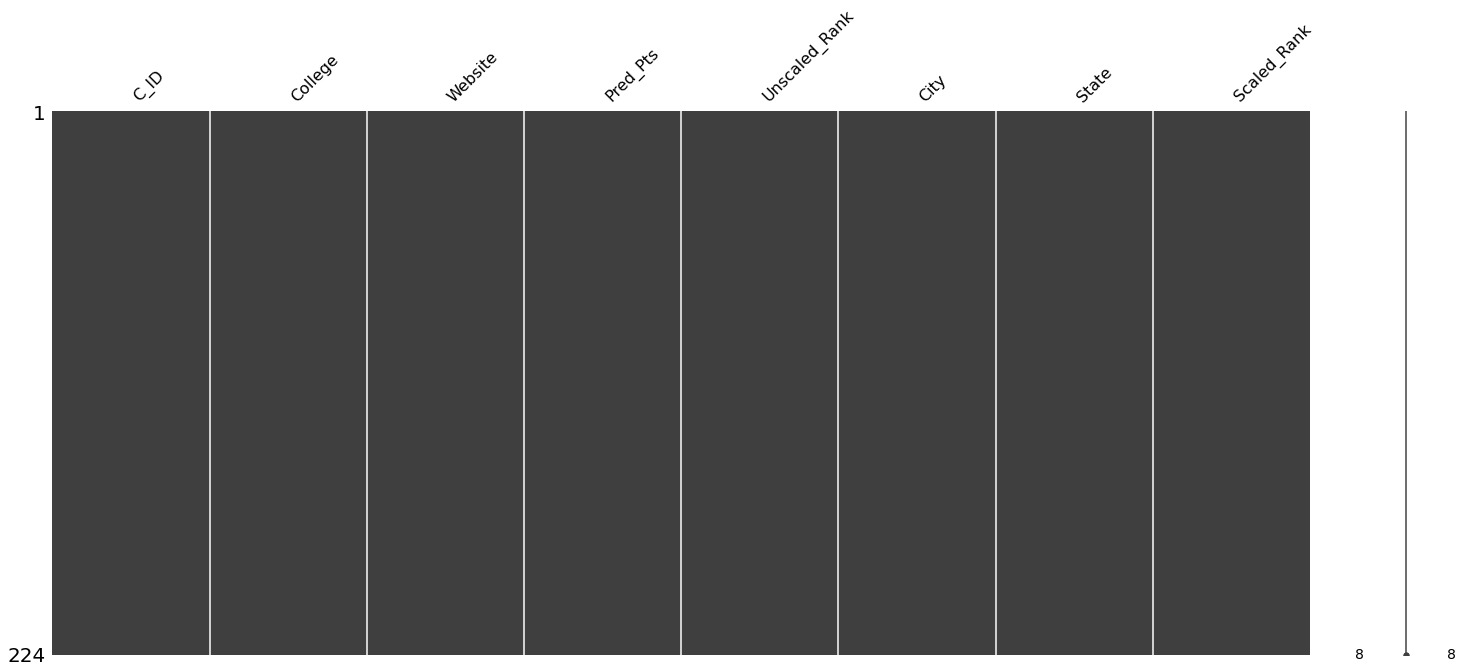

In [11]:
# TEST CALL
df = model_builder(model_select='LASSO', 
                   location_mode = 2)
msno.matrix(df);

In [12]:
df.head(100)

,C_ID,College,Website,Pred_Pts,Unscaled_Rank,City,State,Scaled_Rank
0,FL,University of Florida,www.ufl.edu,788.239343,4,Gainesville,FL,1
1,MIST,Michigan State University,www.msu.edu,770.250672,7,East Lansing,MI,2
2,MICH,University of Michigan at Ann Arbor,www.umich.edu,748.067118,10,Ann Arbor,MI,3
3,UIUC,University of Illinois - Urbana,illinois.edu,707.316132,11,Champaign,IL,4
4,UGA,University of Georgia,www.uga.edu,652.745068,16,Athens,GA,5
5,IND,Indiana University at Bloomington,www.indiana.edu,616.641645,23,Bloomington,IN,6
6,PITT,University of Pittsburgh-Main Campus,www.pitt.edu,605.472849,24,Pittsburgh,PA,7
7,UTK,University of Tennessee at Knoxville,www.utk.edu,568.327790,26,Knoxville,TN,8
8,VT,Virginia Tech,vt.edu,555.998060,30,Blacksburg,VA,9
9,NCST,North Carolina State University at Raleigh,www.ncsu.edu,554.084536,31,Raleigh,NC,10
